In [82]:
# Load my Packages
import requests
import json
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Assign hidden API key
with open("api_stuff.txt", "r") as file:
    api_key = file.read()

In [4]:
# Extract Teams info from API
urlt = "https://api-nba-v1.p.rapidapi.com/teams"

headers = {
	"X-RapidAPI-Key": api_key,
	"X-RapidAPI-Host": "api-nba-v1.p.rapidapi.com"
}

teams = requests.get(urlt, headers=headers)
t_df = pd.DataFrame(teams.json()['response'])

# Select only the ones in the nba Franchise
t_df = t_df[t_df['nbaFranchise'] == True]


In [ ]:
# Get players info from API
urlp = "https://api-nba-v1.p.rapidapi.com/players"

# Create empty dataframe
columns = ['id', 'firstname', 'lastname', 'birth', 'nba', 'height', 'weight', 'college', 'affiliation', 'leagues']
players_df = pd.DataFrame(columns=columns)
teams = []
team_ids = []

# For each team
for team in t_df['id']:
	querystring = {"team": str(team), "season": "2023"}

	headers = {
		"X-RapidAPI-Key": api_key,
		"X-RapidAPI-Host": "api-nba-v1.p.rapidapi.com"
	}

	players = requests.get(urlp, headers=headers, params=querystring)

	p_df = pd.DataFrame(players.json()['response'])

	# add each player info season and team to my players df
	players_df = pd.concat([players_df, p_df], ignore_index=True)

	# Keep track of team and team id
	team_ids.append(team)
	teams.append(t_df[t_df['id'] == team]['code'])

players_df['team_id'] = team_ids
players_df['team'] = teams


In [68]:
# Clean Players Data

# Add Birth date column
players_df['birth_date'] = players_df['birth'].apply(lambda x: pd.to_datetime(x['date']) if x['date'] else None)

# Add height in meters column
players_df['height_m'] = players_df['height'].apply(lambda x: float(x['meters']) if x['meters'] else None)

# Add weight in kilograms column
players_df['weight_kg'] = players_df['weight'].apply(lambda x: float(x['kilograms']) if x['kilograms'] else None)

# Remove unnecessary columns
players_df = players_df[['id', 'firstname', 'lastname', 'birth_date', 'height_m', 'weight_kg']]

# Remove players with NAs
players_df = players_df.dropna()

# Create Age column
players_df['age'] = (datetime.now() - players_df['birth_date']).astype('<m8[Y]').astype(int)

In [87]:
players_df

,id,firstname,lastname,birth_date,height_m,weight_kg,age
0,382,Dejounte,Murray,1996-09-19,1.93,81.6,27
1,1858,Bruno,Fernando,1998-08-15,2.06,108.9,25
2,1046,Trae,Young,1998-09-19,1.85,74.4,25
3,1868,De'Andre,Hunter,1997-12-02,2.03,100.2,25
5,2629,Onyeka,Okongwu,2000-12-11,2.03,108.9,22
...,...,...,...,...,...,...,...
189,287,Cory,Joseph,1991-08-20,1.90,90.7,32
190,204,Draymond,Green,1990-03-04,1.98,104.3,33
191,354,Rodney,McGruder,1991-07-29,1.93,93.0,32
192,548,Andrew,Wiggins,1995-02-23,2.01,89.4,28


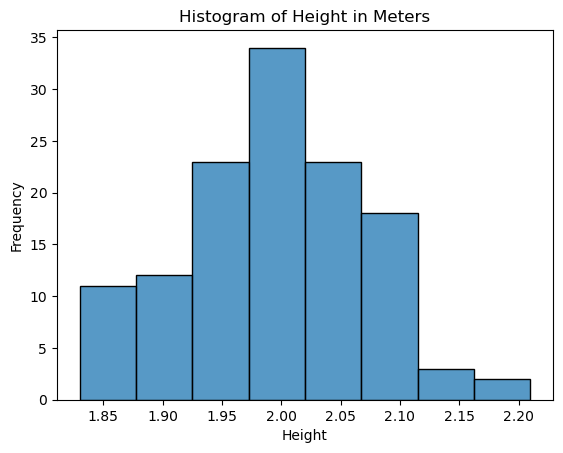

In [77]:
# Heigth Histogram
sns.histplot(players_df['height_m'])

# Optional: Customize plot labels and title
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Histogram of Height in Meters')

# Show the plot
plt.show()

In [78]:
# Min height
players_df['height_m'].min()

1.83

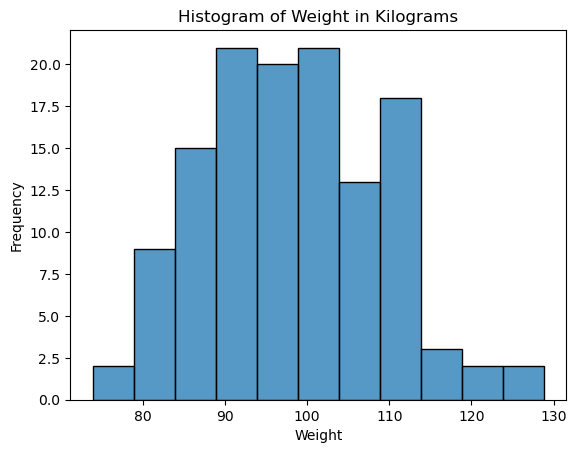

In [79]:
# Weight Histogram

# Heigth Histogram
sns.histplot(players_df['weight_kg'])

# Optional: Customize plot labels and title
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Histogram of Weight in Kilograms')

# Show the plot
plt.show()

In [80]:
# Min height
players_df['weight_kg'].min()

73.9

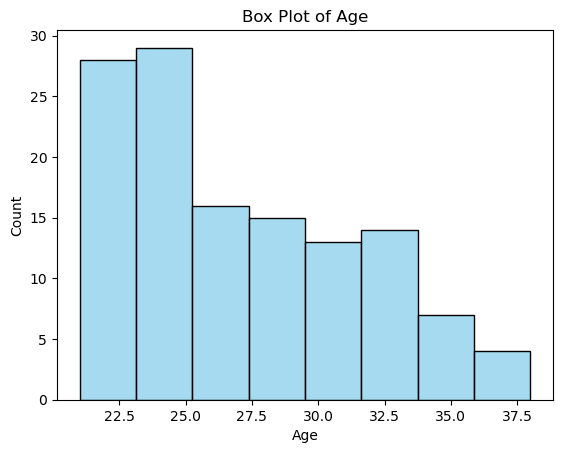

In [92]:
# Age boxplot
sns.histplot(x=players_df['age'], color='skyblue')

# Optional: Customize plot labels and title
plt.xlabel('Age')
plt.title('Age Distribution')

# Show the plot
plt.show()


In [6]:
# Get Player Stats per game info from API
urlps = "https://api-nba-v1.p.rapidapi.com/players/statistics"

querystring = {"id":"236","season":"2023"}

headers = {
	"X-RapidAPI-Key": api_key,
	"X-RapidAPI-Host": "api-nba-v1.p.rapidapi.com"
}

player_stats = requests.get(urlps, headers=headers, params=querystring)
ps = pd.DataFrame(player_stats.json()['response'])

In [24]:
# Create my desired table
ps

,player,team,game,points,pos,min,fgm,fga,fgp,ftm,...,offReb,defReb,totReb,assists,pFouls,steals,turnovers,blocks,plusMinus,comment
0,"{'id': 236, 'firstname': 'Buddy', 'lastname': ...","{'id': 30, 'name': 'Sacramento Kings', 'nickna...",{'id': 8137},23,SG,23:01,8,17,47.1,2,...,0,0,0,1,1,1,0,0,-14,None
1,"{'id': 236, 'firstname': 'Buddy', 'lastname': ...","{'id': 30, 'name': 'Sacramento Kings', 'nickna...",{'id': 8150},6,SG,25:40,2,10,20.0,0,...,0,3,3,7,2,1,1,0,4,None
2,"{'id': 236, 'firstname': 'Buddy', 'lastname': ...","{'id': 30, 'name': 'Sacramento Kings', 'nickna...",{'id': 8159},18,SG,23:42,6,14,42.9,1,...,0,3,3,2,1,1,0,1,0,None
3,"{'id': 236, 'firstname': 'Buddy', 'lastname': ...","{'id': 30, 'name': 'Sacramento Kings', 'nickna...",{'id': 8169},11,SG,29:36,3,13,23.1,2,...,0,5,5,1,2,1,3,0,-10,None
4,"{'id': 236, 'firstname': 'Buddy', 'lastname': ...","{'id': 30, 'name': 'Sacramento Kings', 'nickna...",{'id': 7527},22,SG,41:07,7,15,46.7,3,...,1,3,4,3,5,1,3,0,-2,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,"{'id': 236, 'firstname': 'Buddy', 'lastname': ...","{'id': 30, 'name': 'Sacramento Kings', 'nickna...",{'id': 9253},14,SG,28:53,5,11,45.5,0,...,1,4,5,7,0,1,1,2,30,None
71,"{'id': 236, 'firstname': 'Buddy', 'lastname': ...","{'id': 30, 'name': 'Sacramento Kings', 'nickna...",{'id': 9268},21,SG,30:36,8,15,53.3,0,...,0,3,3,6,4,1,4,0,17,None
72,"{'id': 236, 'firstname': 'Buddy', 'lastname': ...","{'id': 30, 'name': 'Sacramento Kings', 'nickna...",{'id': 7763},16,SG,34:39,6,17,35.3,0,...,1,3,4,6,2,1,2,0,-4,None
73,"{'id': 236, 'firstname': 'Buddy', 'lastname': ...","{'id': 30, 'name': 'Sacramento Kings', 'nickna...",{'id': 7771},11,SG,28:44,4,9,44.4,0,...,1,1,2,5,2,0,2,0,-3,None


In [17]:
s

[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

In [19]:
t_df[t_df['nbaFranchise'] == True]

,id,name,nickname,code,city,logo,allStar,nbaFranchise,leagues
0,1,Atlanta Hawks,Hawks,ATL,Atlanta,https://upload.wikimedia.org/wikipedia/fr/e/ee...,False,True,"{'standard': {'conference': 'East', 'division'..."
1,2,Boston Celtics,Celtics,BOS,Boston,https://upload.wikimedia.org/wikipedia/fr/thum...,False,True,"{'standard': {'conference': 'East', 'division'..."
3,4,Brooklyn Nets,Nets,BKN,Brooklyn,https://upload.wikimedia.org/wikipedia/commons...,False,True,"{'standard': {'conference': 'East', 'division'..."
4,5,Charlotte Hornets,Hornets,CHA,Charlotte,https://upload.wikimedia.org/wikipedia/fr/thum...,False,True,"{'standard': {'conference': 'East', 'division'..."
5,6,Chicago Bulls,Bulls,CHI,Chicago,https://upload.wikimedia.org/wikipedia/fr/thum...,False,True,"{'standard': {'conference': 'East', 'division'..."
6,7,Cleveland Cavaliers,Cavaliers,CLE,Cleveland,https://upload.wikimedia.org/wikipedia/fr/thum...,False,True,"{'standard': {'conference': 'East', 'division'..."
7,8,Dallas Mavericks,Mavericks,DAL,Dallas,https://upload.wikimedia.org/wikipedia/fr/thum...,False,True,"{'standard': {'conference': 'West', 'division'..."
8,9,Denver Nuggets,Nuggets,DEN,Denver,https://upload.wikimedia.org/wikipedia/fr/thum...,False,True,"{'standard': {'conference': 'West', 'division'..."
9,10,Detroit Pistons,Pistons,DET,Detroit,https://upload.wikimedia.org/wikipedia/commons...,False,True,"{'standard': {'conference': 'East', 'division'..."
10,11,Golden State Warriors,Warriors,GSW,Golden State,https://upload.wikimedia.org/wikipedia/fr/thum...,False,True,"{'standard': {'conference': 'West', 'division'..."
